Use historical data for the  New Germany Fund (GF) to predict closing price for new five days


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [94]:
data_path = 'input/stock_prices_sample.csv'
df = pd.read_csv(data_path, index_col = 'DATE', parse_dates = ['DATE'])

In [95]:
df.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [96]:
df.dtypes

TICKER          object
FIGI            object
TYPE            object
FREQUENCY       object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
VOLUME         float64
ADJ_OPEN       float64
ADJ_HIGH       float64
ADJ_LOW        float64
ADJ_CLOSE      float64
ADJ_VOLUME     float64
ADJ_FACTOR     float64
EX_DIVIDEND    float64
SPLIT_RATIO    float64
dtype: object

In [97]:
df.index


DatetimeIndex(['2013-01-04', '2013-01-03', '2013-01-02', '2018-06-05',
               '2018-06-04', '2018-06-01', '2018-05-31', '2018-05-30',
               '2018-05-29', '2018-05-25',
               ...
               '2014-07-07', '2014-07-03', '2014-07-02', '2014-07-01',
               '2014-06-30', '2014-06-27', '2014-06-26', '2014-06-25',
               '2014-06-24', '2014-06-23'],
              dtype='datetime64[ns]', name='DATE', length=999, freq=None)

In [98]:
def mape(y_pred, y_test):
    mape = 100*np.mean(np.abs((y_test-y_pred)/y_test))

Investigate types of funds - TICKER

In [99]:
df['TICKER'].unique()

array(['GEF', 'GF'], dtype=object)

In [100]:
df = df[df['TICKER']=='GF'] # only use ticker 'GF'

Investigate types of types - TYPE

In [101]:
df['TYPE'].unique()

array(['Intraday', 'EOD'], dtype=object)

In [102]:
df = df[df['TYPE']=='EOD'] # only look at 'EOD' - closing prices

In [103]:
cols_to_use = ['TICKER', 'OPEN', 'HIGH', 'LOW', 'CLOSE']
df = df[cols_to_use]
df.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


In [104]:
print('min timestamp', df.index.values.min())
print('max timestamp', df.index.values.max())

min timestamp 2014-06-23T00:00:00.000000000
max timestamp 2018-06-04T00:00:00.000000000


Plot closing price

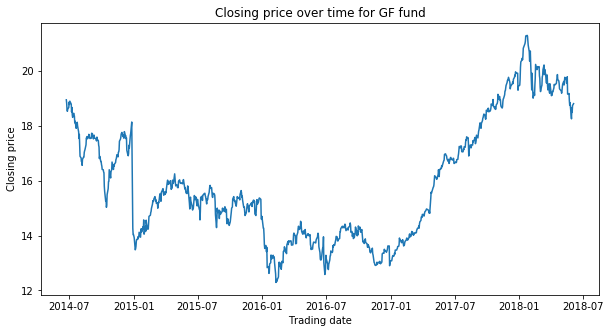

In [105]:
plt.figure(figsize = (10,5))
plt.plot(df['CLOSE'])
#df['CLOSE'].plot()
plt.title('Closing price over time for GF fund')
plt.xlabel('Trading date')
plt.ylabel('Closing price')
plt.show()

#### Use moving average to smooth out curve


In [106]:
def plot_moving_average(data, window, plot_CI = False, Z = 1.96):
    rolling_mean = data.rolling(window = window).mean()
  
    plt.figure(figsize = (10,5))
    plt.plot(data[window:], label = 'Actual values')
    plt.plot(rolling_mean, label = 'Rolling mean with window {}'.format(window))
    plt.title('Actual value and rolling mean')
    plt.xlabel('Trading day')
    plt.ylabel('Closing price')
    
    if plot_CI:
        mae = mean_absolute_error(data[window:], rolling_mean[window:])
        std = np.std(data[window:] - rolling_mean[window:])
        upper_bound = rolling_mean + (mae + Z*std/len(rolling_mean))
        lower_bound = rolling_mean - (mae + Z*std/len(rolling_mean))
        plt.plot(upper_bound, 'r--', label = 'upper bound')
        plt.plot(lower_bound, 'r--', label = 'lower bound')
    
    plt.legend()


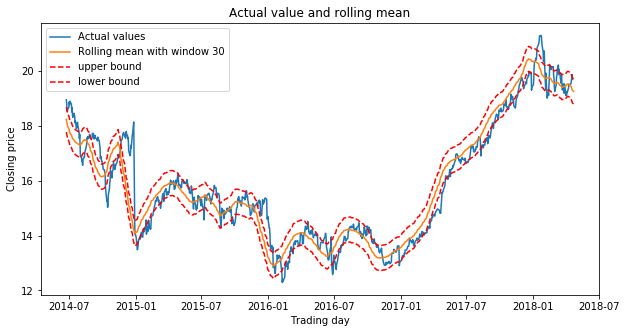

In [107]:
plot_moving_average(df['CLOSE'], window = 30, plot_CI = True)

#### Lag plot


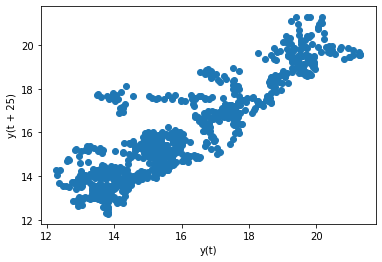

In [108]:
pd.plotting.lag_plot(df['CLOSE'], lag = 25)

#### ACF and PACF

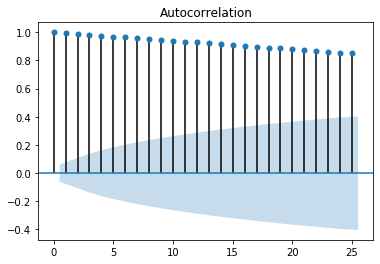

In [109]:
plot_acf(df['CLOSE'], lags = 25)
plt.show()

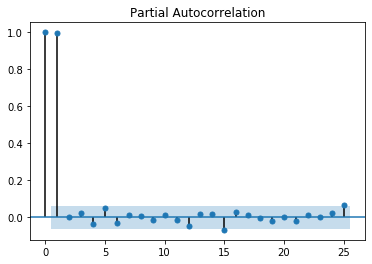

In [110]:
plot_pacf(df['CLOSE'], lags = 25)
plt.show()

Use ACF and PACF to determine the parametervalues to use for AR, MA or ARIMA model

In [111]:
diff_series = df['CLOSE'].diff(periods = 1)

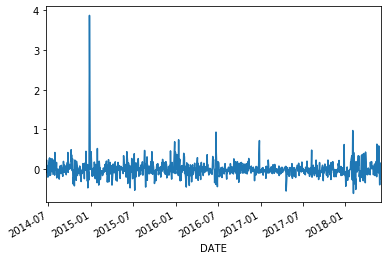

In [112]:
diff_series.plot()

#### Non seasonal ARIMA model


In [113]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [114]:
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [115]:
pdq = [(1,0,0)]

In [116]:

for param in pdq:
    model = ARIMA(df['CLOSE'], param)
    model_fit = model.fit()
    print(model_fit.summary())
    

                              ARMA Model Results                              
Dep. Variable:                  CLOSE   No. Observations:                  995
Model:                     ARMA(1, 0)   Log Likelihood                 156.690
Method:                       css-mle   S.D. of innovations              0.206
Date:                Fri, 24 Apr 2020   AIC                           -307.380
Time:                        10:53:24   BIC                           -292.672
Sample:                             0   HQIC                          -301.788
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          16.9036      1.402     12.053      0.000      14.155      19.652
ar.L1.CLOSE     0.9960      0.003    384.074      0.000       0.991       1.001
                                    Roots       

/Users/kajsa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [117]:
residuals = pd.DataFrame(model_fit.resid)

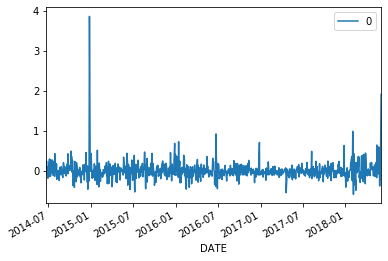

In [118]:
residuals.plot()

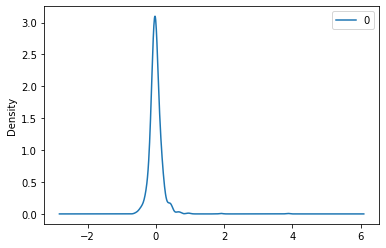

In [119]:
residuals.plot(kind='kde')

In [120]:
print(residuals.describe())

                0
count  995.000000
mean    -0.001908
std      0.214919
min     -0.597943
25%     -0.093024
50%     -0.017449
75%      0.064454
max      3.859474


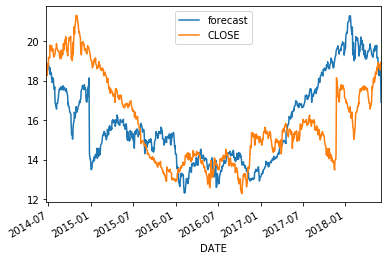

In [121]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [165]:
data = df['CLOSE'].sort_index()

In [166]:
size = int(len(data) * 0.8)

In [167]:
train = data[0:size]
test = data[size:len(data)]

In [168]:
model = ARIMA(train, (0,2,1))
model_fit = model.fit()

/Users/kajsa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kajsa/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [169]:
fc, se, conf = model_fit.forecast(199, alpha = 0.05)

In [170]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

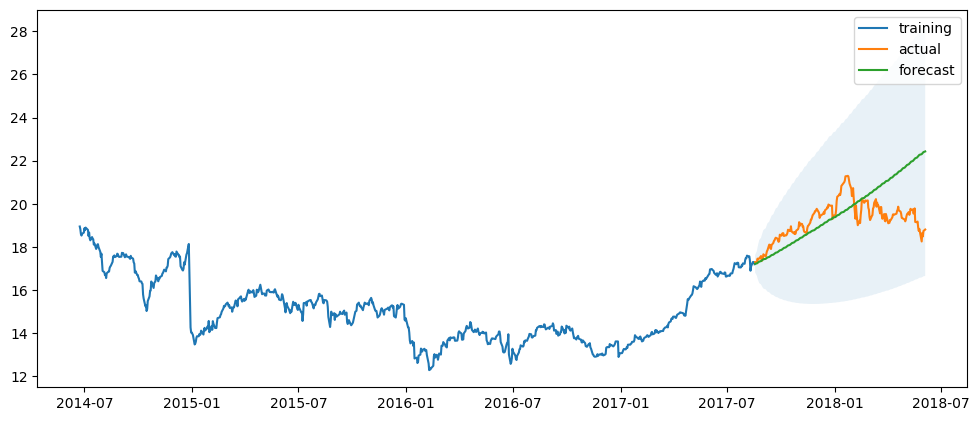

In [171]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label = 'forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha = 0.1)
plt.legend()


In [172]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.CLOSE   No. Observations:                  794
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 113.718
Method:                       css-mle   S.D. of innovations              0.209
Date:                Fri, 24 Apr 2020   AIC                           -221.437
Time:                        11:05:48   BIC                           -207.405
Sample:                             2   HQIC                          -216.044
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.702e-05   3.23e-05      1.767      0.078   -6.22e-06       0.000
ma.L1.D2.CLOSE    -1.0000      0.003   -299.639      0.000      -1.007      -0.993
                                    

#### Forecast metrics

In [173]:
def forecast_metrics(forecast, actual):
    mae = np.mean(np.abs(forecast-actual))
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))*100
    rmse = np.sqrt(np.mean(forecast-actual)**2)
    corr_coef = np.corrcoef(forecast, actual)[0,1]
    return mae, mape, rmse, corr_coef

In [174]:
mae, mape, rmse, corr_coef = forecast_metrics(fc_series, test)

In [175]:
print('mae: ', mae, ', mape: ', mape, ', rmse: ', rmse, ', corr_coef: ', corr_coef)

mae:  1.0461914356413469 , mape:  5.401405786996032 , rmse:  0.3744495844710955 , corr_coef:  0.5009136125292358


### Predict with rolling schedule instead

In [186]:
train_arr = train.values
test_arr = test.values

In [177]:
history = [x for x in train_arr]

In [178]:
params = (1,1,1)
predictions = []
for i in range(len(test_arr)):
    
    model = ARIMA(history, param)
    model_fit = model.fit()
    result = model_fit.forecast()
    forecast = result[0]
    obs = test_arr[i]
    predictions.append(forecast[0])
    history.append(obs)
    

/Users/kajsa/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [179]:
predictions = np.array(predictions)

In [180]:
mae, mape, rmse, corr_coef  = forecast_metrics(predictions, test_arr)

In [181]:
print('mae: ', mae, ', mape: ', mape, ', rmse: ', rmse, ', corr_coef: ', corr_coef)

mae:  0.14017536252915322 , mape:  0.7251216971748837 , rmse:  0.018090911359022934 , corr_coef:  0.9741068998894096


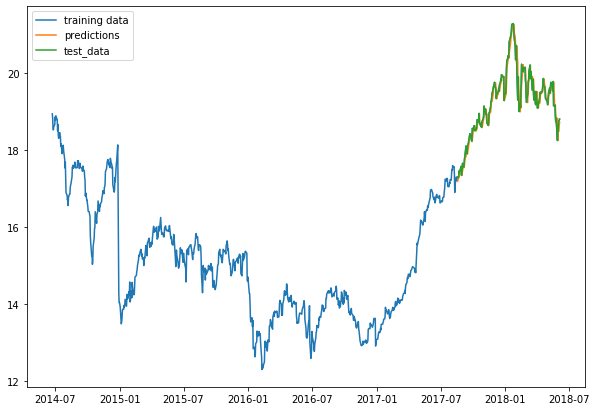

In [201]:
plt.figure(figsize = (10,7))
plt.plot(df['CLOSE'], label = 'training data')
plt.plot(test.index, predictions, label = 'predictions')
plt.plot(test.index, test.values, label = 'test_data' )
plt.legend()